# Este notebook trata da importação do dataframe que servirá de base para os modelos de aprendizagem de máquina e está dividido da seguinte forma:
## 1 - Importa dados dos Termos de Guardas (itenstg.csv)
## 2 - Analisa e processa coluna 'ncm'
## 3 - Cria funções auxiliares para o processamento da coluna descrição
## 4 - Analisa e processa coluna 'descricao'
## 5 - Cria a coluna 'descricao_limpa'
## 6 - Cria a coluna 'descricao_limpa_sem_stopwords'
## 7 - Cria a coluna 'descricao_limpa_stemming'
## 8 - Cria a coluna 'descricao_limpa_sem_stopwords_stemming'

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import unicodedata
import re

import nltk
from nltk.stem import RSLPStemmer
import operator

from collections import Counter, defaultdict
from wordcloud import WordCloud

import sys
sys.path.append('..')
import extras.processtec as pt


ERROR! Session/line number was not unique in database. History logging moved to new session 181


## 1 - Importa dados dos Termos de Guardas (itenstg.csv)

In [2]:
itenstg = pd.read_csv('../data/itenstg.csv')

In [3]:
itenstg.head()

,descricao,ncm
0,MÁSCARA FACIAL HIDRATANTE EM EMBALAGEM DE 25ML...,33049910
1,DIOCTIL FTALATO EM FLEXI-BAG D/C 20 TONELADAS ...,29173200
2,"SOLA DE CALÇADO, DE BORRACHA, N 39 A, REF XL B...",64062000
3,"SOLA DE CALÇADO, DE BORRACHA, N 40 A, REF XL L...",64062000
4,"SOLA DE CALÇADO, DE BORRACHA, N 39 A, REF XL L...",64062000


## 1.1 - Extrai informações do dataframe:
###    - tamanho 6272 linhas
###    - colunas: 
###        'descricao' - 6272 valores não nulos, tipo Object
###        'ncm' - 5970 valores não nulos, tipo Object

In [4]:
len(itenstg)

6272

In [5]:
itenstg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6272 entries, 0 to 6271
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   descricao  6272 non-null   object
 1   ncm        5970 non-null   object
dtypes: object(2)
memory usage: 98.1+ KB


In [6]:
itenstg.describe()

,descricao,ncm
count,6272,5970
unique,6027,361
top,"BIQUINI, DIVERSOS TAMANHOS E CORES - MARCA LM ...",61143000
freq,17,1050


## 2 - Analisa e processa coluna "ncm"

## 2.1 - Análise de dados faltantes (missing values). Tenta transformar valores em float, o que falhar transformar em 'NaN' para depois excluir

In [7]:
# tenta transformar em float, se não conseguir marca como NaN
for i, value in enumerate(itenstg.ncm):
    try:
        float(value)
    except Exception:
        itenstg.ncm[i] = float('NaN')

In [8]:
# quantidade de itens faltantes na coluna ncm
sum(itenstg.ncm.isna())

303

In [9]:
# apaga todas as linhas do dataframe onde 
# o valor da coluna ncm é valor faltante
itenstg = itenstg.dropna(subset=['ncm'])

In [10]:
# tamanho do dataframe após remoção
# dos valores faltantes
len(itenstg)

5969

## 2.2 - Transforma valores em números inteiros, converte para string e preenche os zeros a esquerda de modo a termos 8 caracteres no total.

In [11]:
itenstg['ncm_str'] = itenstg.ncm.astype(float).astype(int).astype(str)
itenstg['ncm_str'] = itenstg.ncm_str.str.zfill(8)  # preenche zeros a esquerda de modo a termos 8 caracteres no final

## 2.3 Cria colunas "capitulo", "posicao", "subposicao", "item" e "subitem" -

In [12]:
# os dois primeiros dígitos da NCM
itenstg['capitulo'] = itenstg.ncm_str.str[:2]

In [13]:
# terceiro e quarto dígitos da NCM
itenstg['posicao'] = itenstg.ncm_str.str[2:4]

In [14]:
# quinto e sexto dígito da NCM
itenstg['subposicao'] = itenstg.ncm_str.str[4:6]

In [15]:
# sétimo dígito da NCM
itenstg['item'] = itenstg.ncm_str.str[6]

In [16]:
# oitavo dígito da NCM
itenstg['subitem'] = itenstg.ncm_str.str[7]

In [17]:
# apaga se tiver capitulo '00' - no DF original havia uma linha de teste com esse valor
itenstg = itenstg.drop(itenstg[itenstg['capitulo'] == '00'].index)

In [18]:
len(itenstg)

5968

In [19]:
itenstg.head()

,descricao,ncm,ncm_str,capitulo,posicao,subposicao,item,subitem
0,MÁSCARA FACIAL HIDRATANTE EM EMBALAGEM DE 25ML...,33049910,33049910,33,04,99,1,0
1,DIOCTIL FTALATO EM FLEXI-BAG D/C 20 TONELADAS ...,29173200,29173200,29,17,32,0,0
2,"SOLA DE CALÇADO, DE BORRACHA, N 39 A, REF XL B...",64062000,64062000,64,06,20,0,0
3,"SOLA DE CALÇADO, DE BORRACHA, N 40 A, REF XL L...",64062000,64062000,64,06,20,0,0
4,"SOLA DE CALÇADO, DE BORRACHA, N 39 A, REF XL L...",64062000,64062000,64,06,20,0,0


## 2.4 - Análise estatística da coluna 'capítulo'.

### 2.4.1 Cria dicionário contendo o somatório total de cada capítulo

In [20]:
# cira dicionário com somatório total de itens na coluna
capitulos = {}
for value in itenstg.capitulo:
    if capitulos.get(value):
        capitulos[value] += 1
    else:
        capitulos[value] = 1

### 2.4.2 ordena do capítulos em ordem decrescente de quantidade

In [21]:
# ordena dicionário em ordem decrescente de quantidade
capitulos = dict(sorted(capitulos.items(), key=lambda item: item[1],reverse=True))
# exibe os 10 itens com mais registros
[(capitulo, qtidd) for capitulo, qtidd in capitulos.items() if qtidd > 50]

[('61', 1803),
 ('84', 1317),
 ('62', 911),
 ('95', 511),
 ('85', 321),
 ('42', 197),
 ('39', 179),
 ('90', 126),
 ('48', 76),
 ('33', 58)]

### 2.4.3 Gráfico de barras da quantidade de capítulos

Text(0, 0.5, 'Quantidade')

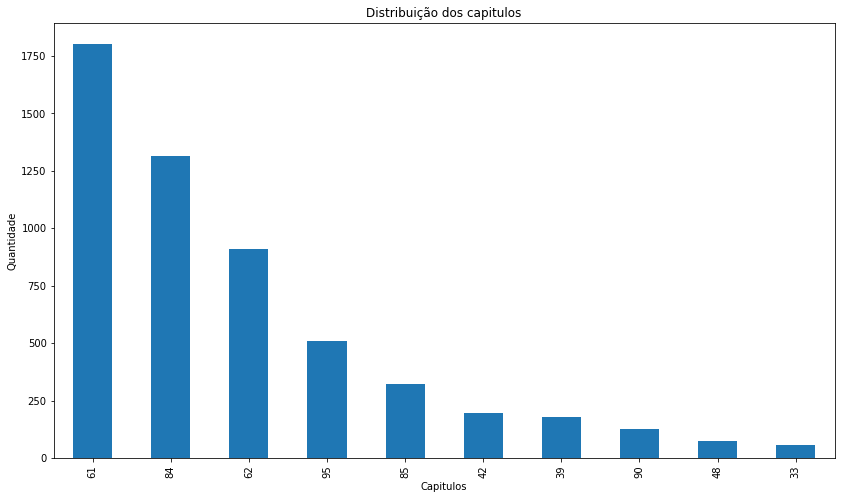

In [22]:
# Cria gráfico de barras
values = itenstg['capitulo'].value_counts()  # conta quantidade de valores da coluna capítulo
threshold = 50  # define limite inferior para exibição no gráfico (exibir 10 primeiros )
mask = values > threshold  
values = values.loc[mask] # pega os valores que devem ser exibidos

# informações do gráfico
ax = values.plot(kind='bar', figsize=(14,8), title="Distribuição dos capitulos")
ax.set_xlabel("Capitulos")
ax.set_ylabel("Quantidade")

## Conclusão - Considerando que temos 5968 itens na coluna 'capitulo', os com maior representatividade (quantidade maior que 50 itens) são:'61', '84', '62', '95',  '85',  '42',  '39',  '90',  '48',  '33'

## 2.5 - Análise estatística da coluna 'posicao'.

In [23]:
# cira dicionário com somatório total de itens na coluna
posicao = {}
for value in itenstg.posicao:
    if posicao.get(value):
        posicao[value] += 1
    else:
        posicao[value] = 1

# ordena dicionário em ordem decrescente de quantidade
posicao = dict(sorted(posicao.items(), key=lambda item: item[1],reverse=True))
# exibe os 10 itens com mais registros
[(item,qtidd) for item, qtidd in posicao.items() if qtidd > 100]

[('82', 1238),
 ('14', 1090),
 ('04', 668),
 ('06', 658),
 ('03', 609),
 ('02', 414),
 ('26', 161),
 ('10', 141),
 ('05', 117),
 ('17', 105)]

Text(0, 0.5, 'Quantidade')

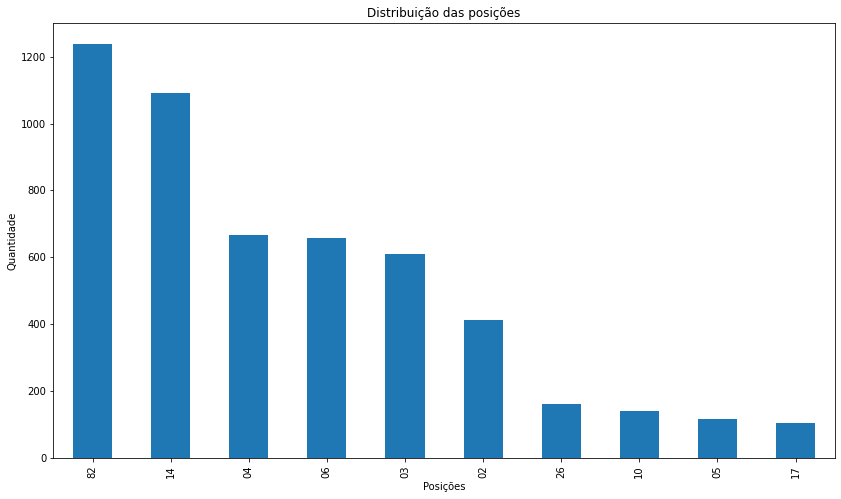

In [24]:
# Cria gráfico de barras
values = itenstg['posicao'].value_counts()  # conta quantidade de valores da coluna capítulo
threshold = 100  # define limite inferior para exibição no gráfico (exibir 10 primeiros )
mask = values > threshold  
values = values.loc[mask] # pega os valores que devem ser exibidos

# informações do gráfico
ax = values.plot(kind='bar', figsize=(14,8), title="Distribuição das posições")
ax.set_xlabel("Posições")
ax.set_ylabel("Quantidade")

## Conclusão - Considerando que temos 5968 itens na coluna 'posicao', os com maior representatividade (quantidade maior que 100 itens) são: 82, 14, 04, 06 e 03

## 2.6 - Análise estatística da coluna 'subposicao'.

In [25]:
# cira dicionário com somatório total de itens na coluna
subposicao = {}
for value in itenstg.subposicao:
    if subposicao.get(value):
        subposicao[value] += 1
    else:
        subposicao[value] = 1

# ordena dicionário em ordem decrescente de quantidade
subposicao = dict(sorted(subposicao.items(), key=lambda item: item[1],reverse=True))
# exibe os 10 itens com mais registros
[(item,qtidd) for item, qtidd in subposicao.items() if qtidd > 100]

[('30', 1378),
 ('10', 1004),
 ('50', 557),
 ('00', 541),
 ('20', 389),
 ('40', 372),
 ('90', 283),
 ('63', 197),
 ('43', 125),
 ('92', 117)]

Text(0, 0.5, 'Quantidade')

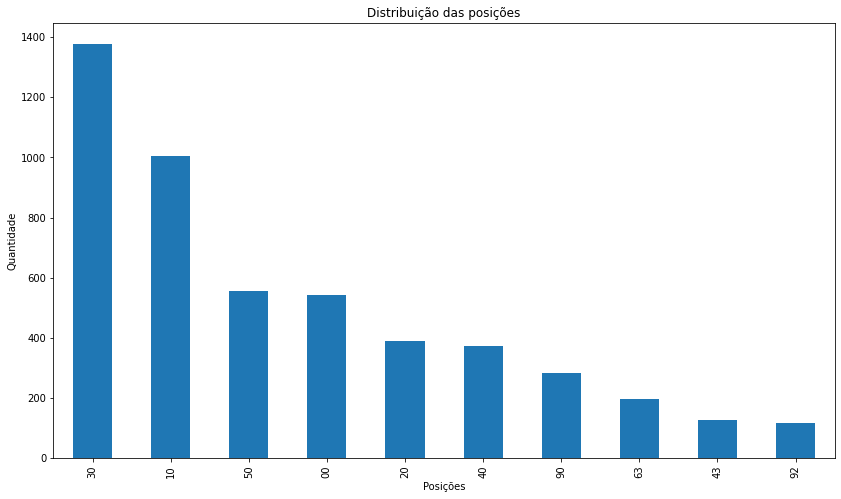

In [26]:
# Cria gráfico de barras
values = itenstg['subposicao'].value_counts()  # conta quantidade de valores da coluna capítulo
threshold = 100  # define limite inferior para exibição no gráfico (exibir 10 primeiros )
mask = values > threshold  
values = values.loc[mask] # pega os valores que devem ser exibidos

# informações do gráfico
ax = values.plot(kind='bar', figsize=(14,8), title="Distribuição das posições")
ax.set_xlabel("Posições")
ax.set_ylabel("Quantidade")

## Conclusão - Considerando que temos 5968 itens na coluna 'subposicao', os com maior representatividade (quantidade maior que 100 itens) são: 30, 10, 50, 00, 20, 40 e 90.

## 2.7 - Análise estatística das colunas 'item' e 'subitem'.

Text(0, 0.5, 'Quantidade')

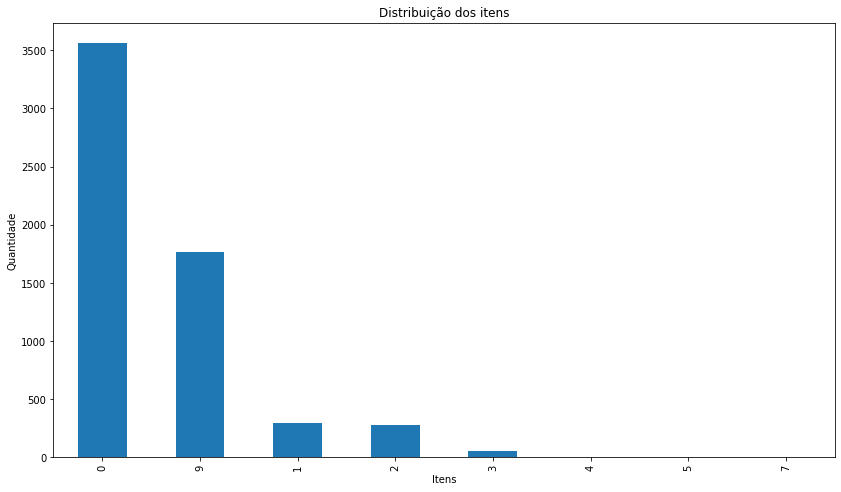

In [27]:
# Cria gráfico de barras
values = itenstg['item'].value_counts()  # conta quantidade de valores da coluna capítulo

# informações do gráfico
ax = values.plot(kind='bar', figsize=(14,8), title="Distribuição dos itens")
ax.set_xlabel("Itens")
ax.set_ylabel("Quantidade")

Text(0, 0.5, 'Quantidade')

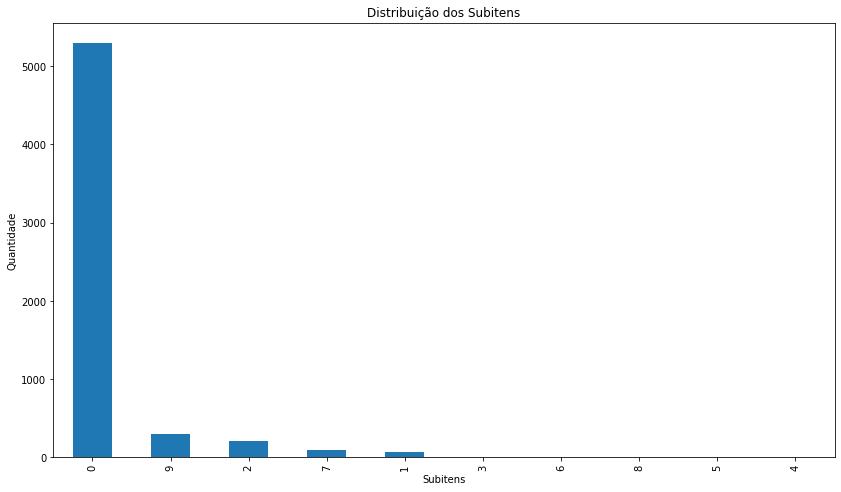

In [28]:
# Cria gráfico de barras
values = itenstg['subitem'].value_counts()  # conta quantidade de valores da coluna capítulo

ax = values.plot(kind='bar', figsize=(14,8), title="Distribuição dos Subitens")
ax.set_xlabel("Subitens")
ax.set_ylabel("Quantidade")

## Conclusão: a coluna item não possui valores 6 e 8 e a coluna subitem contém todos valores entre 0 e 9.

## 2.8 - Capítulos Faltantes:

In [29]:
print(f'O dataframe itens não contém o(s) capitlo(s):')
for i in range(96):
    if len(itenstg[itenstg['capitulo'] == str(i+1).zfill(2)]) == 0:
        print(f'{str(i+1).zfill(2)}', end=' ')

O dataframe itens não contém o(s) capitlo(s):
01 02 03 04 05 06 09 10 11 12 13 14 17 18 24 25 26 27 28 31 36 37 41 43 45 46 47 50 51 53 54 55 57 58 60 72 74 75 77 78 79 86 88 89 

## 3 - Cria funções que serão úteis para o processamento do texto do dataframe

## 3.1 - Função que remove sinais de pontuação

In [30]:
def remove_accents(input_str):  
    """ 
    Função converte string em bytes, mas antes normaliza string usando NFKD
    
    NFKD - decompõem em dois code point e analisa compatibilidades (sem ser canonicamente equivalente)
    https://docs.python.org/3/library/unicodedata.html
    """
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii

## 3.2 - Função que retorna somente o radical da palavra passada como parâmetro

In [31]:
st = RSLPStemmer()
def stem_word(word):
    if word != b'':
        word = st.stem(word.decode("utf-8"))  # pega o radical das palavras
        word = str.encode(word)
    return word

## 3.3 - Função que verifica se é CPF ou CNPJ

In [32]:
def cpf_ou_cnpj(string):
    if re.search(
         "^([0-9]{2}[\.]?[0-9]{3}[\.]?[0-9]{3}[\/]?[0-9]{4}[-]?[0-9]{2})|([0-9]{3}[\.]?[0-9]{3}[\.]?[0-9]{3}[-]?[0-9]{2})$",
         word):
        return True
    return False    

## 3.4 - Função que processa o texto:
## a) convertendo para minúsculo
## b) removendo sinais de pontuação, 
## c) removendo sinais ortográficos,
## d) remove CPF e CNPJ,
## e) removendo stopwords (opcional), 
## f) retorna radicais das palavras - stemming (opcional)

In [33]:
def cria_coluna_descricao(dataframe, col_origem, col_destino, stop_words, stemming=False):
    num_words = Counter()
    word_count = Counter()
    times = 0
    novas_linhas = []
    col_index = dataframe.columns.get_loc(col_origem) + 1 

    for linha in dataframe.itertuples():  # para cada linha da coluna de origem
        lista_linha = re.split('\W+', linha[col_index].strip())  # exclui sinais de pontuação, inclusive espaços
        num_words[len(lista_linha)]+=1  # atualiza contador de quantidade de palavras
        nova_linha = []
        for word in lista_linha:
            word = word.lower()
            if word not in stop_words:  # verifica se não está nos stopword
                # verifica se não é CPF ou CNPJ
                if not cpf_ou_cnpj(word):
                    word = remove_accents(word)  # remove acentuação
                    if stemming:
                        word = stem_word(word)  # retorna somente o radical da palavra 
                    word_count[word]+=1  # atualiza contador de palavras
                    nova_linha.append(word.decode().strip())
        if len(nova_linha) >= 0:
            novas_linhas.append(' '.join(nova_linha))
    
    dataframe[col_destino] = novas_linhas  # cria nova coluna do dataframe com as palavras limpas
    return num_words, word_count

## 4 - Analisa e processa coluna 'descricao', que servirá para criação do vocabulário

## 4.1 - Criação da lista de palavras irrelevantes
## Antes de criar vocabulários é necessário realizar análise das palavras irrelevantes.
## Palavras irrelevantes são aquelas que descrevem a mercadoria num nível muito detalhado, incluindo por exemplo o nome da marca, o número de referência, etc. 
## Exemplo de descrição: 'telefone celular marca samsung', tanto a palavra 'marca' como 'samsung' são irrelevantes para classificação.
## Dessa forma, iremos incluir na lista de stopwords (palavras que deverão ser eliminadas do dataframe) algumas palavras de referência (marca, ref, imitação) e a palavra seguinte a essa.

In [34]:
# conjunto de stopwords - busca palavra posterior
stop_words_posterior = set(['marca', 'ref', 'referencia', 'imitacao', 'modelo', 'no', 
                            'n', 'volume', 'tamanho', 'origem'])
aux = list(stop_words_posterior)
excecao = ['gabinete', 'bulbo', 'eletrico', 'inflavel', 'componentes', 
           'diversas', 'diversos', 'digital', 'estatuetas', 'microfibra', 
          'transparentes', 'headphone', 'bracelete', 'feminino']

In [35]:
# busca as palavras seguintes à stopword
for linha in itenstg['descricao']:
    linha = remove_accents(linha).decode()
    linha = linha.lower()
    for word in aux:
        if word in linha.split():  # garante que a stopword existe na linha
            posi = re.search(r'\b(' + word + r')\b', linha).start()
            if posi:
                try:
                    stop_word = linha[posi:].split()[1]  # pega a palavra posterior à palavra procurada
                    if not stop_word in excecao:
                        stop_words_posterior.add(stop_word)
                except IndexError:
                    pass

In [36]:
# conjunto de stopwords - busca palavra anterior
stop_words_anterior = set(['g', 'gramas', 'kg', 'kilos', 'kilograma', 
                           'kilogramas', 'quilo','quilos', 'ml', 'l', 
                           'litro', 'litros', 'mm', 'cm', 'm', 'giga', 
                           'gigabyte', 'gigabytes', 'gb', 'tera', 'terabyte', 
                           'terabytes', 'tb'])
aux = list(stop_words_anterior)

In [37]:
# busca as palavras anteriores à stopword
for linha in itenstg['descricao']:
    linha = remove_accents(linha).decode()
    linha = linha.lower()
    for word in aux:
        if word in linha.split():  # garante que a stopword existe na linha
            posi = re.search(r'\b(' + word + r')\b', linha).start()
            if posi:
                try:
                    stop_word = linha[:posi].split()[-1]  # pega a palavra anterior à palavra procurada
                    stop_words_anterior.add(stop_word)
                except IndexError:
                    pass

In [38]:
# quantidade de stopwords posterior e anterior 1437/ 50 -- total 1689
len(stop_words_posterior), len(stop_words_anterior)

(1419, 51)

In [39]:
stop_words_itens = stop_words_posterior.union(stop_words_anterior)
len(stop_words_itens)

1466

In [40]:
# conjunto de stopwords 
stop_words_outras = set(['2020', '2019', 'parte', 'kit', 'c3', 's', '', '5', '35', '65', '95', '10',
                        'brazil', '2020', '2019', 'parte', 'kit', 'xiaomi', 'huawei', '', '4gb', 
                         '32gb', '64gb', '128gb', '100ml', '750ml', 'no', '9', '8', '100', 'c'])

# concatena conjuntos de palavras
stop_words_itens = stop_words_itens.union(stop_words_outras)

# tamanho do conjunto que será adicionado à lista de stopwords
# da biblioteca NLTK
len(stop_words_itens)

1488

## 4.2 - Adicionar as palavras irrelevantes na lista de stopwords da biblioteca nltk

In [41]:
# recupera as stopwords da biblioteca NLTK
stopwords = nltk.corpus.stopwords.words('portuguese')

# adiciona o conjunto à lista de stopwords da biblioteca
[stopwords.append(_) for _ in stop_words_itens]

# apaga repetidas
stopwords = list(set(stopwords)) 

# quantidade de stopwords final
print(len(stopwords))

1680


## 5 - Cria a coluna 'descricao_limpa'
## 5.1 - Nessa coluna não foram retiradas as stopwords e também não foram retirados os afixos 

In [42]:
# cria a coluna descricao_limpa sem informar nenhuma stopword e sem fazer o stemming
num_words, word_count = cria_coluna_descricao(itenstg, 'descricao', 'descricao_limpa', "", False)

In [43]:
# compara item da coluna descricao com a descricao_limpa dele
itenstg.loc[8].descricao, itenstg.loc[8].descricao_limpa

('LÂMINA DE SERRA DE FITA, REF 03163. ', 'lamina de serra de fita ref 03163')

In [44]:
# 20 palavras mais comuns (com maior freq acumulada)
word_count.most_common(20)

[(b'marca', 3910),
 (b'imitacao', 2599),
 (b'ref', 2016),
 (b'poliester', 1999),
 (b'de', 1631),
 (b'da', 1594),
 (b'rolamento', 1229),
 (b'feminina', 1094),
 (b'feminino', 1047),
 (b'referencia', 988),
 (b'100', 964),
 (b'modelo', 894),
 (b'malha', 846),
 (b'blusa', 810),
 (b'elastano', 766),
 (b'com', 704),
 (b'algodao', 645),
 (b'plano', 587),
 (b'5', 571),
 (b'tecido', 569)]

## 5.2 - Nuvem de palavras - 50 palavras mais frequentes

In [45]:
# cria um dicionário temporário 'text' com as 50 palavras mais frequentes
max_values = 50
text = {}
for (k, v) in word_count.most_common(max_values):
    text[str(k.decode())] = v

In [46]:
# cria a nuvem de palavras
wordcloud = WordCloud(width=1600, height=800).generate_from_frequencies(text)

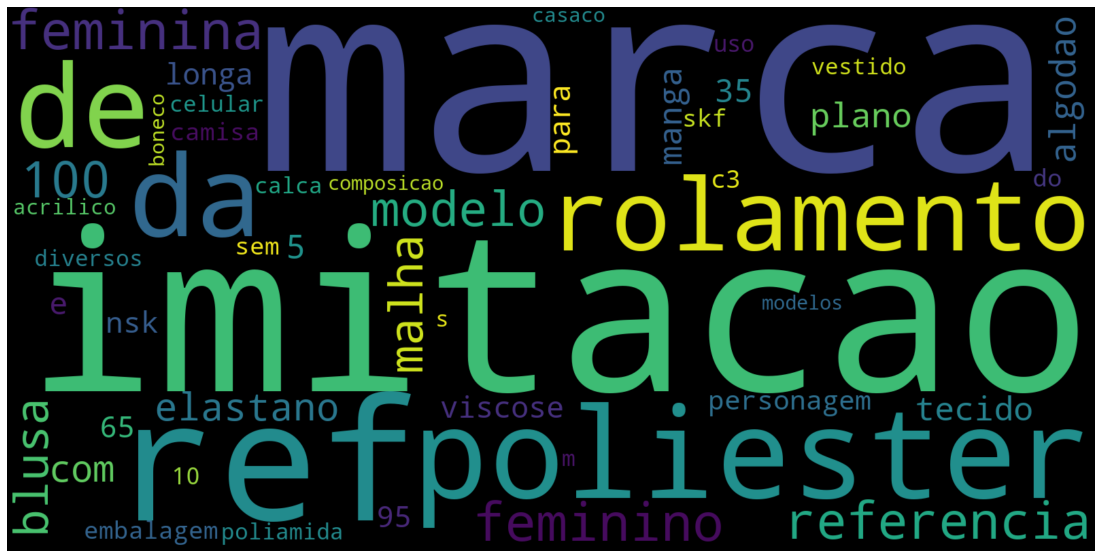

In [47]:
# configurações de plotagem
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.show()

In [48]:
# Cria dataframe com as 50 palavras mais frequentes
df_word_count = pd.DataFrame()
df_word_count['descricao_limpa'] = text.keys()
df_word_count.head(10)

,descricao_limpa
0,marca
1,imitacao
2,ref
3,poliester
4,de
5,da
6,rolamento
7,feminina
8,feminino
9,referencia


### Conclusão: Pelo fato de não termos retirado as stopwords, as palavras mais frequentes foram "marca", "imitação" e "ref".

## 5.3 - Salva dataframe em formato parquet

In [49]:
# salva em formato parquet
itenstg.to_parquet('1_itenstg_desc_limpa.parquet')

## 6 - Cria a coluna 'descricao_limpa_sem_stopwords'
## 6.1 - Nessa coluna foram retiradas as stopwords para termos descrições com palavras mais importantes. 
## Não foram retirados os afixos 

In [50]:
# cria a coluna descricao_limpa_sem_stopwords informando as stopwords, mas sem fazer o stemming
num_words, word_count = cria_coluna_descricao(itenstg, 'descricao', 'descricao_limpa_sem_stopwords', stopwords, False)

In [51]:
itenstg.loc[8].descricao, itenstg.loc[8].descricao_limpa_sem_stopwords

('LÂMINA DE SERRA DE FITA, REF 03163. ', 'lamina serra fita 03163')

## 6.2 - Nuvem de palavras - 50 palavras mais frequentes

In [52]:
max_values = 50
text = {}
for (k, v) in word_count.most_common(max_values):
    text[str(k.decode())] = v

In [53]:
wordcloud = WordCloud(width=1600, height=800).generate_from_frequencies(text)

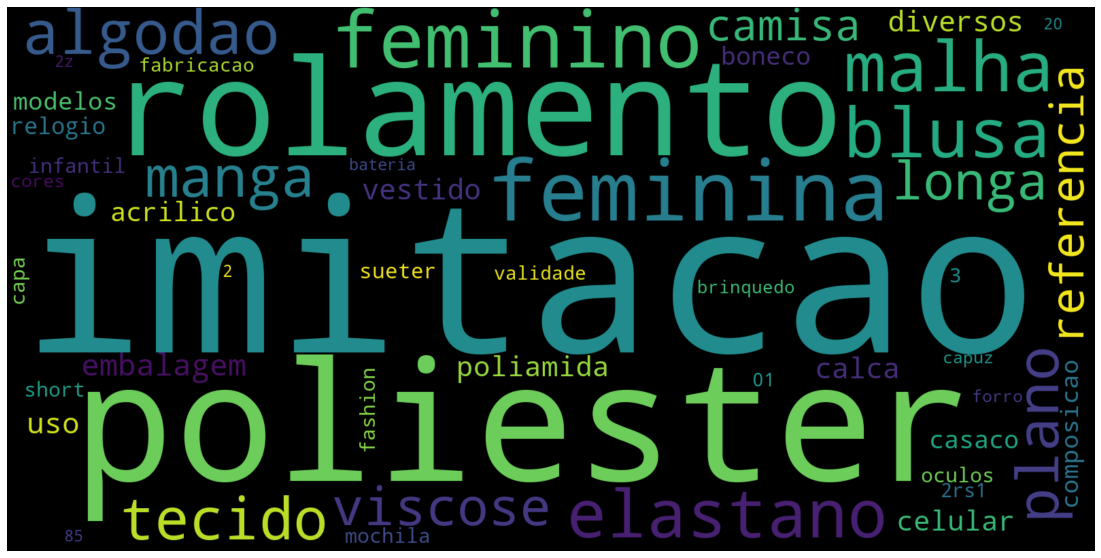

In [54]:
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.show()

In [55]:
df_word_count['descricao_limpa_sem_stopwords'] = text.keys()
df_word_count.head(10)

,descricao_limpa,descricao_limpa_sem_stopwords
0,marca,imitacao
1,imitacao,poliester
2,ref,rolamento
3,poliester,feminina
4,de,feminino
5,da,malha
6,rolamento,blusa
7,feminina,elastano
8,feminino,algodao
9,referencia,plano


### Conclusão: a retirada de stopwords tornou as palavras "imitação", "poliester" e "rolamento" mais frequentes

## 6.3 - Salva dataframe em formato parquet

In [56]:
itenstg.to_parquet('1_itenstg_desc_limpa_sem_stopwords.parquet')  # salva em formato parquet

## 7 - Cria a coluna 'descricao_limpa_stemming'
## 7.1 - Nessa coluna não foram retiradas as stopwords 
## Mas foram retirados os afixos, mantendo somente o radical das palavras

In [57]:
num_words, word_count = cria_coluna_descricao(itenstg, 'descricao', 'descricao_limpa_stemming', "", True)

In [58]:
itenstg.loc[8].descricao, itenstg.loc[8].descricao_limpa_stemming

('LÂMINA DE SERRA DE FITA, REF 03163. ', 'lamin de serr de fit ref 03163')

In [59]:
word_count.most_common(20)

[(b'marc', 3923),
 (b'imitaca', 2599),
 (b'feminin', 2164),
 (b'ref', 2018),
 (b'poliest', 2001),
 (b'de', 1632),
 (b'da', 1618),
 (b'rol', 1241),
 (b'model', 1072),
 (b'referenc', 1049),
 (b'100', 964),
 (b'malh', 846),
 (b'blus', 821),
 (b'elast', 766),
 (b'com', 706),
 (b'algoda', 645),
 (b'plan', 587),
 (b'5', 571),
 (b'tec', 569),
 (b'mang', 561)]

## 7.2 - Nuvem de palavras - 50 palavras mais frequentes

In [60]:
max_values = 50
text = {}
for (k, v) in word_count.most_common(max_values):
    text[str(k.decode())] = v

In [61]:
wordcloud = WordCloud(width=1600, height=800).generate_from_frequencies(text)

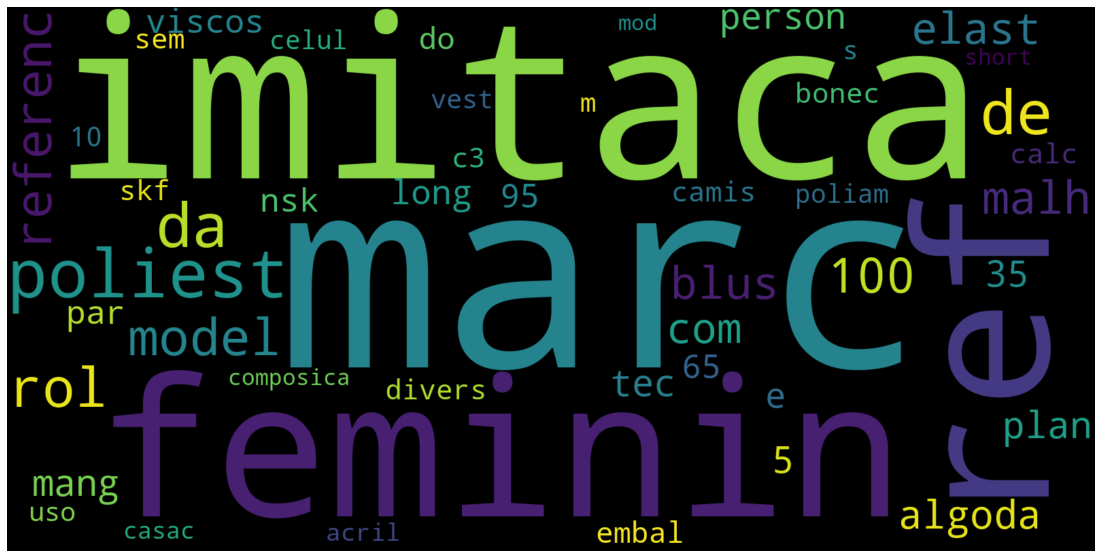

In [62]:
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.show()

In [63]:
df_word_count['descricao_limpa_stemming'] = text.keys()
df_word_count.head(10)

,descricao_limpa,descricao_limpa_sem_stopwords,descricao_limpa_stemming
0,marca,imitacao,marc
1,imitacao,poliester,imitaca
2,ref,rolamento,feminin
3,poliester,feminina,ref
4,de,feminino,poliest
5,da,malha,de
6,rolamento,blusa,da
7,feminina,elastano,rol
8,feminino,algodao,model
9,referencia,plano,referenc


### Conclusão: ainda há o problema das stopwords, mas houve agrupamento de algumas palavras como 'feminino' e 'feminina', 'boneco' e 'boneca', 'diversos' e 'diversas', entre outras. 

# obs: esse dataframe não será utilizado como dado de entrada do modelo

## 7.3 - Salva dataframe em formato parquet

In [64]:
itenstg.to_parquet('1_itenstg_desc_limpa_stemming.parquet')  # salva em formato parquet

## 8 - Cria a coluna 'descricao_limpa_sem_stopwords_stemming'
## 8.1 - Nessa coluna foram retiradas as stopwords e os afixos

In [65]:
# cria a coluna descricao_limpa_sem_stopwords_stemming informando as stopwords e fazendo o stemming
num_words, word_count = cria_coluna_descricao(itenstg, 'descricao', 'descricao_limpa_sem_stopwords_stemming', stopwords, True)

In [66]:
itenstg.loc[8].descricao, itenstg.loc[8].descricao_limpa_sem_stopwords_stemming

('LÂMINA DE SERRA DE FITA, REF 03163. ', 'lamin serr fit 03163')

In [67]:
word_count.most_common(20)

[(b'imitaca', 2599),
 (b'feminin', 2164),
 (b'poliest', 2001),
 (b'rol', 1241),
 (b'malh', 846),
 (b'blus', 821),
 (b'elast', 766),
 (b'algoda', 645),
 (b'plan', 587),
 (b'tec', 569),
 (b'mang', 561),
 (b'long', 487),
 (b'viscos', 453),
 (b'referenc', 410),
 (b'embal', 350),
 (b'camis', 314),
 (b'calc', 308),
 (b'divers', 295),
 (b'bonec', 295),
 (b'uso', 266)]

## 8.2 - Nuvem de palavras - 50 palavras mais frequentes

In [68]:
max_values = 50
text = {}
for (k, v) in word_count.most_common(max_values):
    text[str(k.decode())] = v

In [69]:
wordcloud = WordCloud(width=1600, height=800).generate_from_frequencies(text)

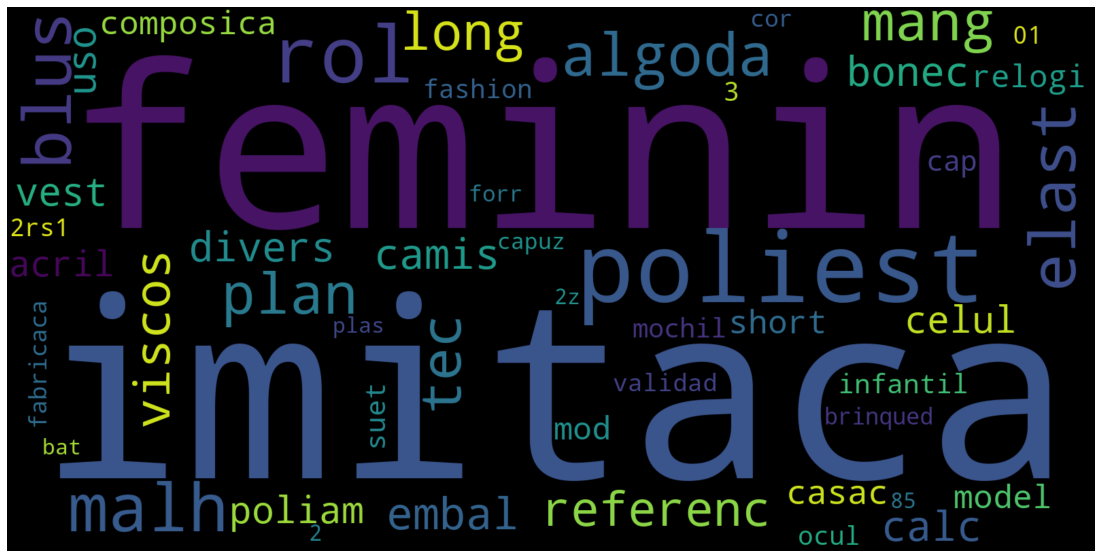

In [70]:
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.show()

In [71]:
df_word_count['descricao_limpa_sem_stopwords_stemming'] = text.keys()

In [72]:
df_word_count = df_word_count.drop('descricao_limpa_stemming', 1)

In [73]:
df_word_count.head(20)

,descricao_limpa,descricao_limpa_sem_stopwords,descricao_limpa_sem_stopwords_stemming
0,marca,imitacao,imitaca
1,imitacao,poliester,feminin
2,ref,rolamento,poliest
3,poliester,feminina,rol
4,de,feminino,malh
5,da,malha,blus
6,rolamento,blusa,elast
7,feminina,elastano,algoda
8,feminino,algodao,plan
9,referencia,plano,tec


### Conclusão: retirando as stopwords e pegando apenas os radicais temos uma base de palavras aparentemente melhor para utilizar na classificação, pois diminui a quantidade de palavras no bag of words.

## 8.3 - Salva dataframe em formato parquet

In [74]:
itenstg.to_parquet('1_itenstg_desc_limpa_sem_stopwords_stemming.parquet')  # salva em formato parquet

In [75]:
itenstg.head()

,descricao,ncm,ncm_str,capitulo,posicao,subposicao,item,subitem,descricao_limpa,descricao_limpa_sem_stopwords,descricao_limpa_stemming,descricao_limpa_sem_stopwords_stemming
0,MÁSCARA FACIAL HIDRATANTE EM EMBALAGEM DE 25ML...,33049910,33049910,33,04,99,1,0,mascara facial hidratante em embalagem de 25ml...,mascara facial hidratante embalagem 25ml days ...,masc fac hidrat em embal de 25ml 5 day dre mir...,masc fac hidrat embal 25ml day dre miracl vali...
1,DIOCTIL FTALATO EM FLEXI-BAG D/C 20 TONELADAS ...,29173200,29173200,29,17,32,0,0,dioctil ftalato em flexi bag d c 20 toneladas ...,dioctil ftalato flexi bag d 20 toneladas metri...,dioctil ftalat em flex bag d c 20 tonel metr d...,dioctil ftalat flex bag d 20 tonel metr diocty...
2,"SOLA DE CALÇADO, DE BORRACHA, N 39 A, REF XL B...",64062000,64062000,64,06,20,0,0,sola de calcado de borracha n 39 a ref xl belf...,sola calcado borracha belfast mx,sol de calc de borrach n 39 a ref xl belfast mx,sol calc borrach belfast mx
3,"SOLA DE CALÇADO, DE BORRACHA, N 40 A, REF XL L...",64062000,64062000,64,06,20,0,0,sola de calcado de borracha n 40 a ref xl lyon mx,sola calcado borracha lyon mx,sol de calc de borrach n 40 a ref xl lyon mx,sol calc borrach lyon mx
4,"SOLA DE CALÇADO, DE BORRACHA, N 39 A, REF XL L...",64062000,64062000,64,06,20,0,0,sola de calcado de borracha n 39 a ref xl lyon mx,sola calcado borracha lyon mx,sol de calc de borrach n 39 a ref xl lyon mx,sol calc borrach lyon mx
